# Markov Chain Monte Carlo

In [1]:
import math
import pandas as pd
import seaborn as sns
import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, NUTS

from rethinking import MAP, extract_samples, precis

### Code 8.1

In [2]:
num_weeks = int(1e5)
positions = torch.tensor(0).repeat(num_weeks)
current = 9
for i in range(num_weeks):
    # record current position
    positions[i] = current

    # flip coin to generate proposal
    sample = torch.multinomial(torch.ones(2), num_samples=1)
    proposal = current + torch.tensor([-1, 1])[sample].item()
    # now make sure he loops around the archipelago
    if proposal < 0:
        proposal = 9
    if proposal > 9:
        proposal = 0
    
    # move?
    prob_move = (proposal + 1) / (current + 1)
    current = proposal if torch.rand(1) < prob_move else current

### Code 8.2

In [3]:
rugged = pd.read_csv("../data/rugged.csv", sep=";")
d = rugged
d["log_gdp"] = d["rgdppc_2000"].apply(math.log)
dd = d[d["rgdppc_2000"].notnull()]

### Code 8.3

In [4]:
def model(rugged, cont_africa, log_gdp):
    a = pyro.sample("a", dist.Normal(0, 100))
    bR = pyro.sample("bR", dist.Normal(0, 10))
    bA = pyro.sample("bA", dist.Normal(0, 10))
    bAR = pyro.sample("bAR", dist.Normal(0, 10))
    mu = a + bR * rugged + bA * cont_africa + bAR * rugged * cont_africa
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        pyro.sample("log_gdp", dist.Normal(mu, sigma), obs=log_gdp)

dd.index = range(dd.shape[0])
dd_rugged = torch.tensor(dd["rugged"], dtype=torch.float)
dd_cont_africa = torch.tensor(dd["cont_africa"], dtype=torch.float)
dd_log_gdp = torch.tensor(dd["log_gdp"], dtype=torch.float)
m8_1 = MAP(model).run(dd_rugged, dd_cont_africa, dd_log_gdp)
precis(m8_1)

,Mean,StdDev,|0.89,0.89|
a,9.23,0.14,9.01,9.46
bR,-0.20,0.08,-0.33,-0.09
bA,-1.95,0.22,-2.30,-1.59
bAR,0.40,0.13,0.20,0.61
sigma,0.94,0.05,0.85,1.01


### Code 8.4

In [5]:
dd_trim = dd[["log_gdp", "rugged", "cont_africa"]]
dd_trim.info()
dd_trim.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 3 columns):
log_gdp        170 non-null float64
rugged         170 non-null float64
cont_africa    170 non-null int64
dtypes: float64(2), int64(1)
memory usage: 4.1 KB


,log_gdp,rugged,cont_africa
0,7.492609,0.858,1
1,8.216929,3.427,0
2,9.933263,0.769,0
3,9.407032,0.775,0
4,7.792343,2.688,0


### Code 8.5

In [5]:
def model(rugged, cont_africa, log_gdp):
    a = pyro.sample("a", dist.Normal(0, 100))
    bR = pyro.sample("bR", dist.Normal(0, 10))
    bA = pyro.sample("bA", dist.Normal(0, 10))
    bAR = pyro.sample("bAR", dist.Normal(0, 10))
    mu = a + bR * rugged + bA * cont_africa + bAR * rugged * cont_africa
    sigma = pyro.sample("sigma", dist.Uniform(0, 10))
    with pyro.plate("plate"):
        pyro.sample("log_gdp", dist.Normal(mu, sigma), obs=log_gdp)

kernel = NUTS(model)
m8_1stan = MCMC(kernel, num_samples=1000).run(dd_rugged, dd_cont_africa, dd_log_gdp)

### Code 8.6

In [6]:
precis(m8_1stan)

,Mean,StdDev,|0.89,0.89|,n_eff,r_hat
a,9.22,0.14,9.01,9.45,348.24,1.0
bR,-0.20,0.08,-0.32,-0.08,341.69,1.0
bA,-1.94,0.22,-2.29,-1.62,379.23,1.0
bAR,0.39,0.12,0.18,0.58,408.30,1.0
sigma,0.95,0.05,0.86,1.03,509.45,1.0


### Code 8.7 

In [9]:
kernel = NUTS(model)
m8_1stan_4chains = MCMC(kernel, num_samples=1000, num_chains=4)
m8_1stan_4chains.run(dd_rugged, dd_cont_africa, dd_log_gdp)
precis(m8_1stan_4chains)

,Mean,StdDev,|0.89,0.89|,n_eff,r_hat
a,9.20,0.14,9.02,9.44,57.34,1.12
bR,-0.19,0.08,-0.31,-0.06,53.28,1.10
bA,-1.92,0.24,-2.29,-1.55,94.08,1.07
bAR,0.37,0.13,0.15,0.56,66.12,1.08
sigma,0.95,0.05,0.87,1.03,352.25,1.00


### Code 8.8

In [14]:
post = extract_samples(m8_1stan)
{latent: post[latent][:5] for latent in post}

{'a': tensor([9.0925, 9.1057, 9.0637, 9.0636, 9.1352]),
 'bR': tensor([-0.0548, -0.0420, -0.0858, -0.0940, -0.1580]),
 'bA': tensor([-2.1268, -2.0949, -2.0214, -1.7741, -1.6405]),
 'bAR': tensor([0.2960, 0.4054, 0.2992, 0.3229, 0.2452]),
 'sigma': tensor([0.9184, 0.9093, 0.9098, 0.9956, 0.8898])}

### Code 8.9

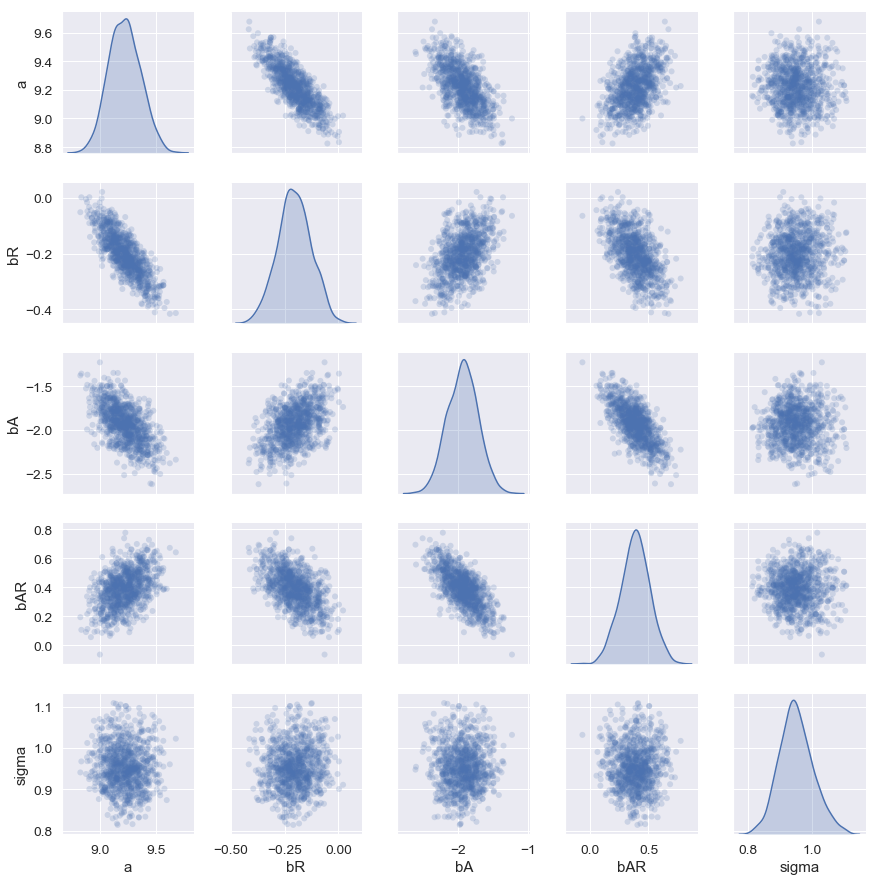

In [24]:
sns.pairplot(pd.DataFrame(post), diag_kind="kde", plot_kws={"edgecolor": "none", "alpha": 0.2});

### Code 8.10

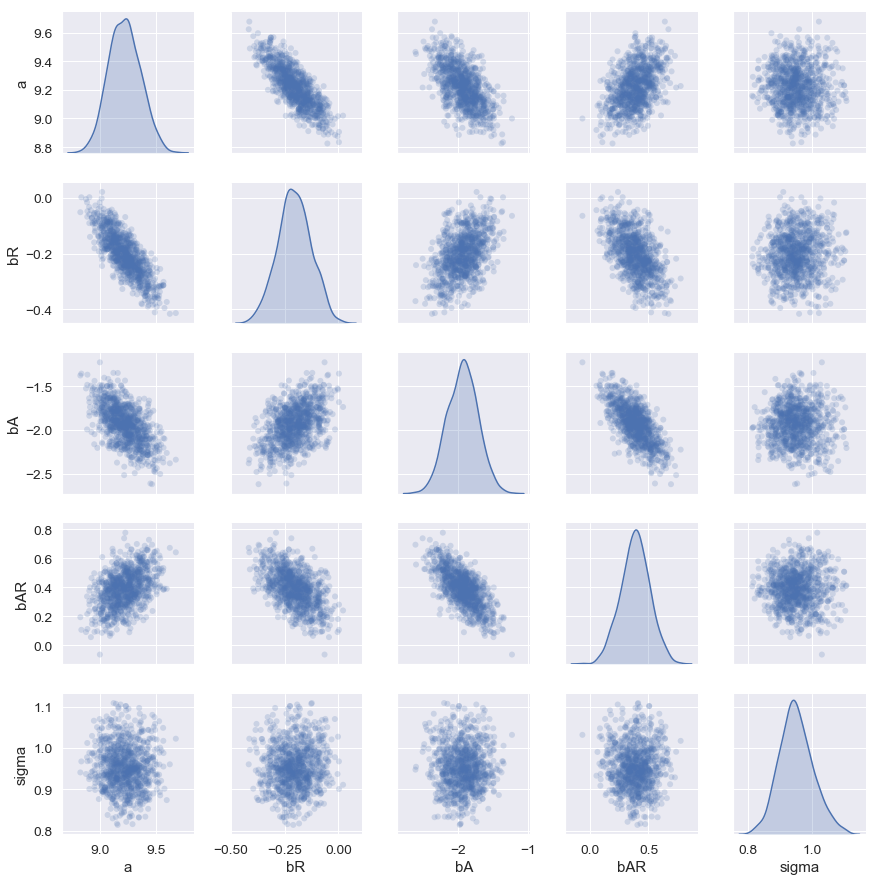

In [25]:
post = extract_samples(m8_1stan)
sns.pairplot(pd.DataFrame(post), diag_kind="kde", plot_kws={"edgecolor": "none", "alpha": 0.2});

### Code 8.12

In [26]:
m8_1stan.information_criterion()

OrderedDict([('waic', tensor(468.6995)), ('p_waic', tensor(4.7904))])

### Code 8.13

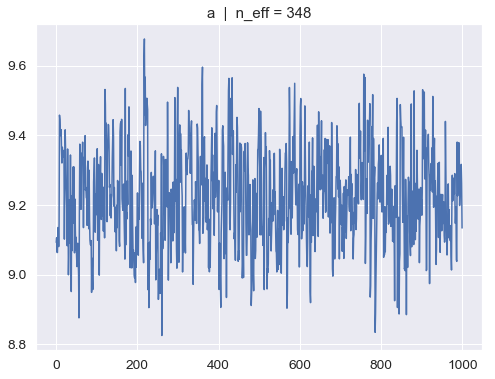

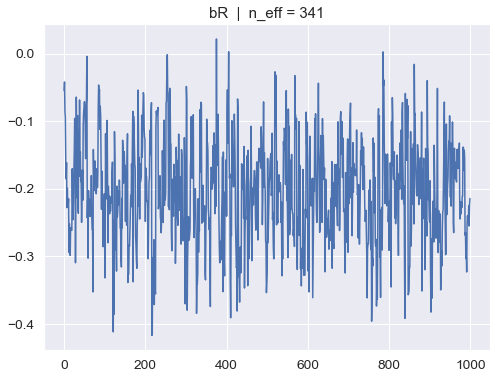

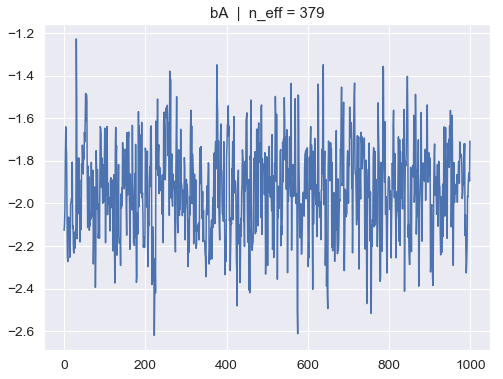

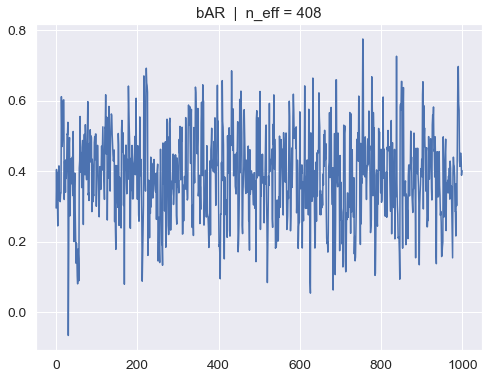

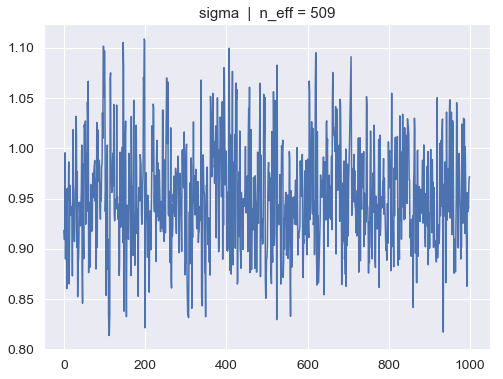

In [36]:
post = extract_samples(m8_1stan)
precis_df = precis(m8_1stan)
for latent in post:
    ax = sns.lineplot(range(1000), post[latent])
    ax.set(title="{}  |  n_eff = {}".format(latent, int(precis_df.loc[latent, "n_eff"])))
    sns.mpl.pyplot.show()

### Code 8.13

In [2]:
y = torch.tensor([-1., 1])

def model(y):
    mu = pyro.sample("alpha", dist.Normal(0, 1000000))
    sigma = pyro.sample("sigma", dist.HalfCauchy(200000))
    with pyro.plate("plate"):
        pyro.sample("y", dist.Normal(mu, sigma), obs=y)

kernel = NUTS(model)
trace = pyro.poutine.trace(model).get_trace(y)
trace.nodes["alpha"]["value"] = torch.tensor(0.)
trace.nodes["sigma"]["value"] = torch.tensor(1.)
kernel.initial_trace = trace
m8_2 = MCMC(kernel, num_samples=3000, warmup_steps=1000, num_chains=2).run(y)

### Code 8.14

In [3]:
precis(m8_2)

,Mean,StdDev,|0.89,0.89|,n_eff,r_hat
alpha,-34.65,6613.46,-6435.84,6599.30,423.19,1.00
sigma,5317.66,12856.32,47.47,13610.39,145.22,1.01


### Code 8.15

In [ ]:
def model(y):
    alpha = pyro.sample("alpha", dist.Normal(1, 10))
    mu = alpha
    sigma = pyro.sample("sigma", dist.HalfCauchy(1))
    with pyro.plate("plate"):
        pyro.sample("y", dist.Normal(mu, sigma), obs=y)

kernel = NUTS(model)
trace = pyro.poutine.trace(model).get_trace(y)
trace.nodes["alpha"]["value"] = torch.tensor(0.)
trace.nodes["sigma"]["value"] = torch.tensor(1.)
kernel.initial_trace = trace
m8_3 = MCMC(kernel, num_samples=3000, warmup_steps=1000, num_chains=2).run(y)
precis(m8_3)

### Code 8.16

In [ ]:
y = dist.Cauchy(0, 5).sample(torch.Size([int(1e4)]))
mu = [sum(y[:i]) / (i + 1) for i in range(y.size(0))]
sns.pointplot(mu)

### Code 8.17

In [ ]:
y = torch.randn(100)

In [ ]:
y

In [ ]:
y <- rnorm( 100 , mean=0 , sd=1 )